In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy.time import Time

from orbitize.results import Results

In [3]:
# load the posteriors from the various orbit fits

nograv_results = Results()
nograv_results.load_results('results/with_literature_astrom/chains.hdf5')

onegrav_results = Results()
onegrav_results.load_results('results/with_literature_astromwith_first_vlti_point/chains.hdf5')

other_onegrav_results = Results()
other_onegrav_results.load_results('results/with_literature_astromwith_second_vlti_point/chains.hdf5')

twograv_results = Results()
twograv_results.load_results('results/with_literature_astromwith_first_vlti_pointwith_second_vlti_point/chains.hdf5')

onlygrav_results = Results()
onlygrav_results.load_results('results/with_first_vlti_pointwith_second_vlti_point/chains.hdf5')

fixed_ecc_results = Results()
fixed_ecc_results.load_results('results/with_literature_astromwith_first_vlti_pointwith_second_vlti_point_fixed_ecc/chains.hdf5')

lin_ecc_results = Results()
lin_ecc_results.load_results('results/with_literature_astromwith_first_vlti_pointwith_second_vlti_point_linear_ecc/chains.hdf5')

all_results = {
    nograv_results: 'literature data only', 
    onegrav_results:'literature + GRAVITY epoch 1' , 
    other_onegrav_results: 'literature + GRAVITY epoch 2', 
    twograv_results: '\\textbf{all data (accepted fit)}',
    onlygrav_results:'GRAVITY data only',
    fixed_ecc_results: 'all data, ecc. fixed to 0',
    lin_ecc_results:'all data, decreasing ecc. prior'
}

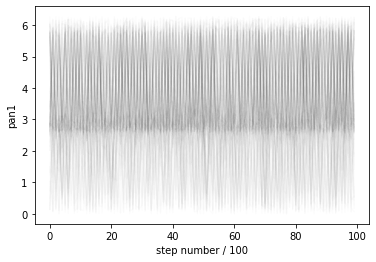

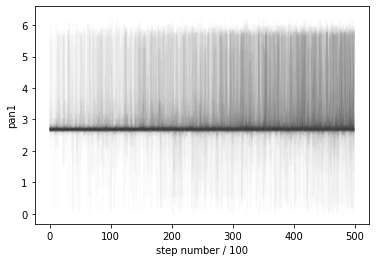

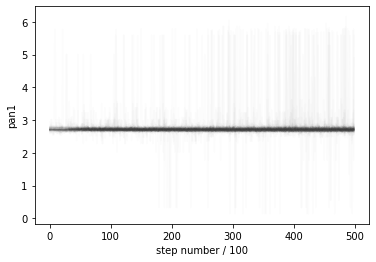

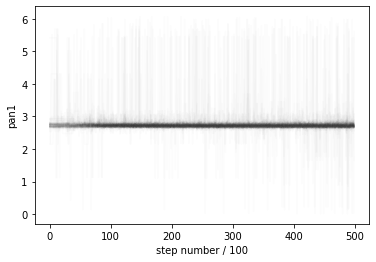

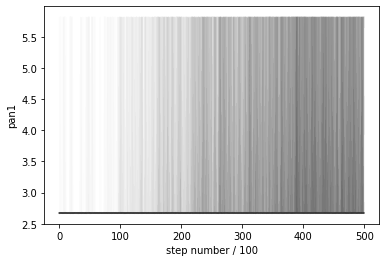

In [6]:
# make MCMC convergence plots

param = 'pan1'

for res in all_results:
    smas = res.post[:, res.system.param_idx[param]]

    num_walkers = 1000
    n_steps = len(smas) // num_walkers
    chn = smas.reshape((num_walkers, n_steps))

    walkers_to_plot = np.random.choice(num_walkers, size=100, replace=False)
    plt.figure()
    for w in walkers_to_plot:
        plt.plot(chn[w, :], color='k', alpha=0.01)
    plt.xlabel('step number / 100')
    plt.ylabel(param)


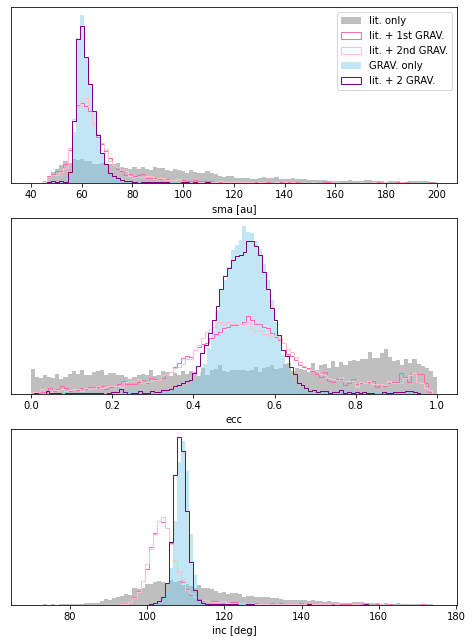

In [103]:
# plot all the sma, ecc, and inc posteriors
fig, ax = plt.subplots(3, 1, figsize=(8,11))
for a in ax:
    a.set_yticks([])

ax[0].set_xlabel('sma [au]')
ax[1].set_xlabel('ecc')
ax[2].set_xlabel('inc [deg]')

plot_dict = {
    nograv_results: {'ec': None, 'fc': 'grey', 'alpha': 0.5, 'histtype':'stepfilled'},
    onegrav_results: {'ec': 'hotpink', 'fc': 'white', 'histtype':'step'},
    other_onegrav_results: {'ec': 'pink', 'fc': 'white', 'histtype':'step'},
    twograv_results: {'ec': 'purple', 'fc': 'white',  'histtype':'step'},
    onlygrav_results: {'ec': None, 'fc': 'skyblue',  'histtype':'stepfilled', 'alpha':0.5}
}

for res, lab in zip(
    [nograv_results, onegrav_results, other_onegrav_results, onlygrav_results, twograv_results],
    ['lit. only', 'lit. + 1st GRAV.', 'lit. + 2nd GRAV.', 'GRAV. only', 'lit. + 2 GRAV.']
):
    ax[0].hist(res.post[:, res.system.param_idx['sma1']], bins=100, range=(40, 200), label=lab, **plot_dict[res], density=True)
    ax[1].hist(res.post[:, res.system.param_idx['ecc1']], bins=100, **plot_dict[res], density=True)
    ax[2].hist(np.degrees(res.post[:, res.system.param_idx['inc1']]), range=(70, 175), bins=100, **plot_dict[res], density=True)

ax[0].legend()
plt.savefig('results/plots/orbit_compare.png', dpi=250)

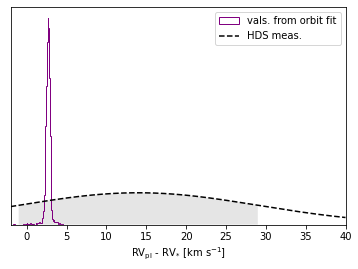

In [63]:
# plot the planetary RV vs the measurement

rv_epoch = twograv_results.data[twograv_results.data['quant_type'] == 'rv']['epoch'].value[0]

# compute the planetary RV at the measured epoch for each posterior sample
_, _, rv_out = twograv_results.system.compute_all_orbits(
    twograv_results.post.T, epochs=np.array([rv_epoch])
)

rv_predictions = rv_out[0,1,:]
plt.figure()
plt.hist(
    rv_predictions, bins=100, density=True, label='vals. from orbit fit', 
    histtype='step', color='purple'
)

# overplot the RV measurement and uncertainty
rv_meas = twograv_results.data[twograv_results.data['quant_type'] == 'rv']['quant1'].value[0]
rv_unc = twograv_results.data[twograv_results.data['quant_type'] == 'rv']['quant1_err'].value[0]

rv2plot = np.linspace(-2, 40, int(1e3))

def norm(x, mu, sig):
    return 1 / (sig * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - mu)/sig)**2)

plt.plot(rv2plot, 10 * norm(rv2plot, rv_meas, rv_unc), label='HDS meas.', color='k', ls='--')
plt.yticks([])
plt.xlabel('RV$_{{\\rm pl}}$ - RV$_{{*}}$ [km s$^{{-1}}$]')
plt.xlim(-2,40)

onesig_rvrange = np.linspace(rv_meas - rv_unc, rv_meas + rv_unc, int(1e3))
plt.fill_between(
    onesig_rvrange, np.zeros(int(1e3)), 10 * norm(onesig_rvrange, rv_meas, rv_unc),
    color='k', alpha=0.1, ec=None
)

plt.legend()
plt.savefig('results/plots/rv_meas.png', dpi=250)

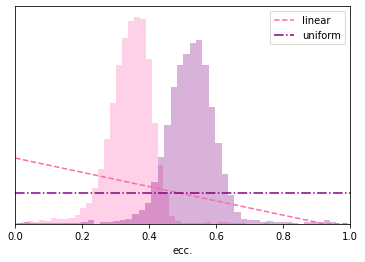

In [26]:
# compare the eccentricity posteriors using different priors

plt.figure()
colors=['hotpink', 'purple']
for i, res in enumerate([lin_ecc_results, twograv_results]):
    plt.hist(res.post[:, res.system.param_idx['ecc1']], bins=50, color=colors[i], alpha=0.3, density=True)

# overplot the prior in each case
m = -2.18
b = 2.01
xplot = np.array([0, -b/m, 1])
norm = -0.5*b**2/m
print(norm)
yplot = (m * xplot + b) / norm
yplot[-1] = 0

plt.plot(xplot, yplot, color=colors[0], ls='--', label='linear')
plt.plot(xplot, np.ones(len(xplot)), color=colors[1], ls='-.', label='uniform')
plt.xlim(0,1)
plt.legend()
plt.yticks([])
plt.xlabel('ecc.')
plt.savefig('results/plots/ecc_compare.png', dpi=250)

0.0
0.5591022111136933


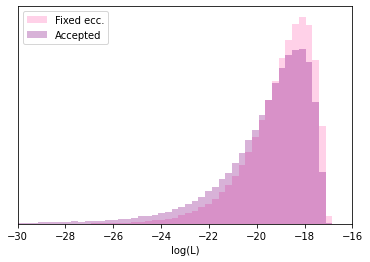

In [105]:
# plot the log-likelihoods for the fixed eccentricity posterior vs the accepted one


plt.figure()
labels = ['Fixed ecc.','Accepted']
colors = ['hotpink','purple']
for i, res in enumerate([fixed_ecc_results, twograv_results]):
    plt.hist(res.lnlike, bins=50, alpha=0.3, density=True, label=labels[i], color=colors[i], range=(-30,-16))
    print(res.post[:,1][np.argmax(res.lnlike)])
    # plt.hist(res.lnlike[res.post[:,1] > 0.4], density=True, alpha=0.5,bins=50, range=(-30,-16))
plt.yticks([])
plt.legend()
plt.xlim(-30,-16)
plt.xlabel('log(L)')
plt.savefig('results/plots/ecc_lnlike_compare.png', dpi=250)

In [102]:
# make an overleaf table of all of the fit results

def format_post(results_obj, el_label, n_decimals=1, degrees=False, dont_print_circ_toggle=False):
    quants = np.quantile(results_obj.post[:, results_obj.system.param_idx[el_label]], [.16, .50, .84])

    if dont_print_circ_toggle:
        return '--'

    if degrees:
        quants = np.degrees(quants)

    med = quants[1]
    up_lim = quants[2] - quants[1]
    lo_lim = quants[1] - quants[0]

    if up_lim == lo_lim:
        if el_label == 'ecc1':
            return '=0'

    
    if np.abs(up_lim - lo_lim) <= 1/(10*n_decimals):
        return '${:.{prec}f}\\pm{{{:.{prec}f}}}$'.format(med, up_lim, prec=n_decimals)

    return '${:.{prec}f}^{{+{:.{prec}f}}}_{{-{:.{prec}f}}}$'.format(
        med, up_lim, lo_lim, prec=n_decimals
    )



for res in all_results.keys():

    dont_print_circ_toggle = False
    if all_results[res] == 'all data, ecc. fixed to 0':
        dont_print_circ_toggle = True

    print('{} & {} & {} & {} & {} & {} & {} & {} & {} \\\\'.format(
        all_results[res],
        format_post(res, 'sma1', n_decimals=1),
        format_post(res, 'ecc1', n_decimals=2),
        format_post(res, 'inc1', n_decimals=1, degrees=True),
        format_post(res, 'aop1', n_decimals=1, degrees=True, dont_print_circ_toggle=dont_print_circ_toggle),
        format_post(res, 'pan1', n_decimals=1, degrees=True),
        format_post(res, 'tau1', n_decimals=2, dont_print_circ_toggle=dont_print_circ_toggle),
        format_post(res, 'plx', n_decimals=2),
        format_post(res, 'mtot', n_decimals=2)
    )
)
    

literature data only & $86.4^{+57.7}_{-26.8}$ & $0.59^{+0.28}_{-0.39}$ & $110.6^{+20.6}_{-11.5}$ & $190.2^{+93.8}_{-127.3}$ & $167.5^{+164.2}_{-29.8}$ & $0.36^{+0.24}_{-0.16}$ & $9.30\pm{0.03}$ & $1.96\pm{0.04}$ \\
literature + GRAVITY epoch 1 & $62.8^{+11.3}_{-5.7}$ & $0.53\pm{0.16}$ & $104.4^{+4.7}_{-3.3}$ & $196.1^{+24.9}_{-23.6}$ & $154.2^{+5.7}_{-2.9}$ & $0.47\pm{0.08}$ & $9.30\pm{0.03}$ & $1.96\pm{0.04}$ \\
literature + GRAVITY epoch 2 & $62.7^{+10.7}_{-5.5}$ & $0.52\pm{0.16}$ & $104.3^{+4.6}_{-3.3}$ & $196.2\pm{22.3}$ & $154.2^{+5.4}_{-2.8}$ & $0.47\pm{0.07}$ & $9.30\pm{0.03}$ & $1.96\pm{0.04}$ \\
\textbf{all data (accepted fit)} & $61.1^{+4.6}_{-2.8}$ & $0.53\pm{0.06}$ & $108.6\pm{1.8}$ & $192.4^{+14.9}_{-11.6}$ & $155.4^{+2.7}_{-2.3}$ & $0.46\pm{0.05}$ & $9.30\pm{0.03}$ & $1.96\pm{0.04}$ \\
GRAVITY data only & $61.1^{+4.7}_{-2.7}$ & $0.53\pm{0.06}$ & $109.3\pm{1.9}$ & $192.7^{+15.9}_{-13.0}$ & $155.6^{+3.3}_{-2.6}$ & $0.46\pm{0.05}$ & $9.30\pm{0.03}$ & $1.96\pm{0.04}$ \\
all d

58849.0


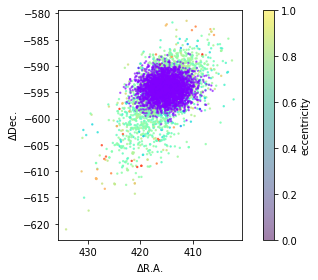

In [7]:
# run the accepted orbit fit posteriors forward in time; plot deltaRA & deltaDec by eccentricity
date = {'year':2050, 'month':5,'day':15}
epoch = Time(date, format='ymdhms')

n_to_plot = 3000
indx = np.random.choice(len(twograv_results.post), size=n_to_plot)

raoff, deoff, _ = twograv_results.system.compute_all_orbits(twograv_results.post[indx,:].T, epochs=np.array([epoch.mjd]))
raoff_pl = raoff[:,1,:][0]
deoff_pl = deoff[:,1,:][0]


print(twograv_results.system.tau_ref_epoch)
fig, ax = plt.subplots()
eccentricities = twograv_results.post[indx,:][:,1]
plt.scatter(raoff_pl, deoff_pl, color=cm.rainbow(eccentricities), alpha=0.75, s=2)


raoff, deoff, _ = fixed_ecc_results.system.compute_all_orbits(fixed_ecc_results.post[indx,:].T, epochs=np.array([epoch.mjd]))
raoff_pl = raoff[:,1,:][0]
deoff_pl = deoff[:,1,:][0]

eccentricities = np.zeros(n_to_plot)
plt.scatter(raoff_pl, deoff_pl, color=cm.rainbow(eccentricities), alpha=0.5, s=2)
plt.ylabel('$\Delta$Dec.')
plt.xlabel('$\Delta$R.A.')
ax.set_xlim((ax.get_xlim()[1], ax.get_xlim()[0]))
ax.set_aspect('equal')

ax_cbar = plt.colorbar()
ax_cbar.set_label('eccentricity')
plt.tight_layout()
plt.savefig('results/plots/orbit_predict{}-{}.png'.format(date['month'], date['year']), dpi=250)